# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [3]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'drive/My Drive/image_arrays_train.zip' .
!cp 'drive/My Drive/image_arrays_test.zip' .

cp: cannot stat 'drive/My Drive/image_arrays_train.zip': No such file or directory
cp: cannot stat 'drive/My Drive/image_arrays_test.zip': No such file or directory


In [4]:
# Extract
!unzip -q image_arrays_train.zip
!unzip -q image_arrays_test.zip

unzip:  cannot find or open image_arrays_train.zip, image_arrays_train.zip.zip or image_arrays_train.zip.ZIP.
unzip:  cannot find or open image_arrays_test.zip, image_arrays_test.zip.zip or image_arrays_test.zip.ZIP.


In [5]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

SampleSubmission.csv  Train.csv


In [6]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Remove all datapoints (images) that have a quality of 1 or less. Quality of 1 or less corresponds to a poor image.

In [3]:
train = train[train.Quality > 1]
print(train.shape)

(2552, 4)


Loading image_arrays_train/MH2O0YH.npy as an array
(360, 41, 41)
(41, 41)


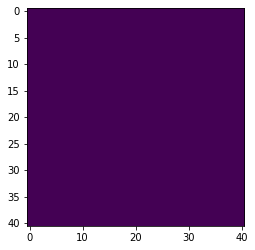

In [4]:
# Look at a sample:
# get a random sample from the dataset
#fid = train['Field_ID'].sample().values[0]
fid = train['Field_ID'].values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')

# load the randomly sampled datapoint image
arr = np.load(fn) # Loading the data with numpy
print(arr.shape)
#print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
#rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = arr[359]
print(rgb_jan.shape)
max_val = np.max(rgb_jan) 
if max_val == 0:
    max_val = 1
rgb_jan = rgb_jan / max_val # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

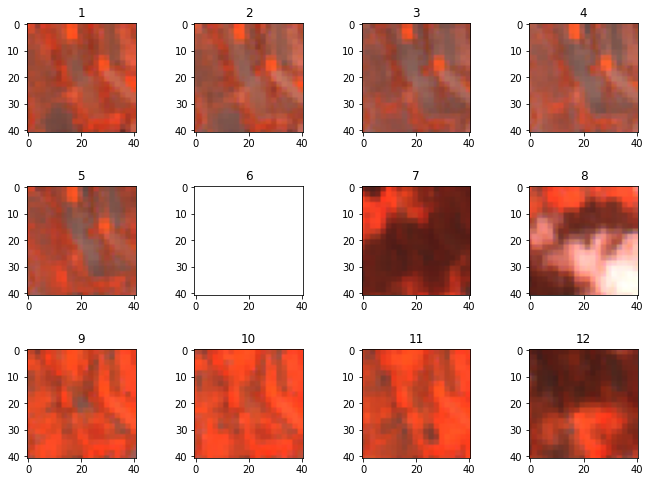

In [5]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

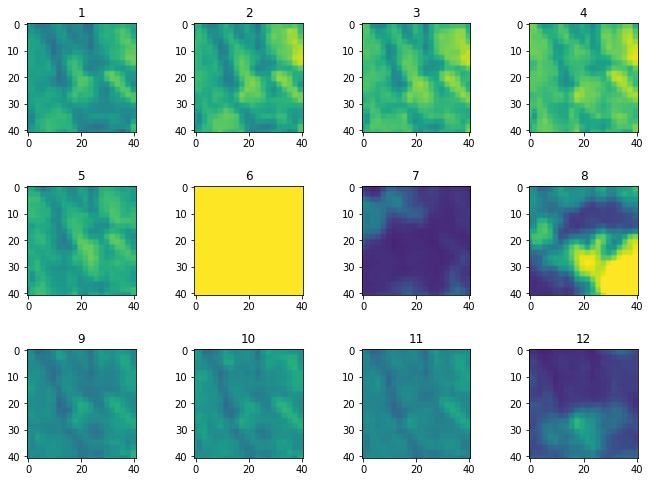

In [6]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

Loading image_arrays_train/FT3VG8R.npy as an array


/home/t440p/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


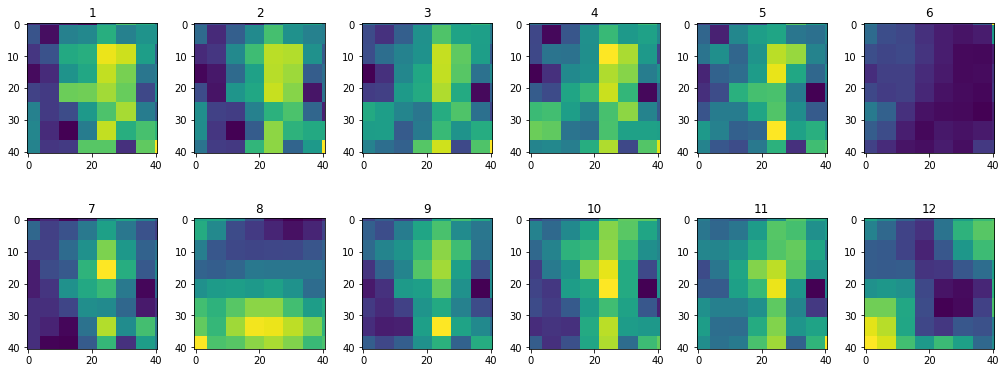

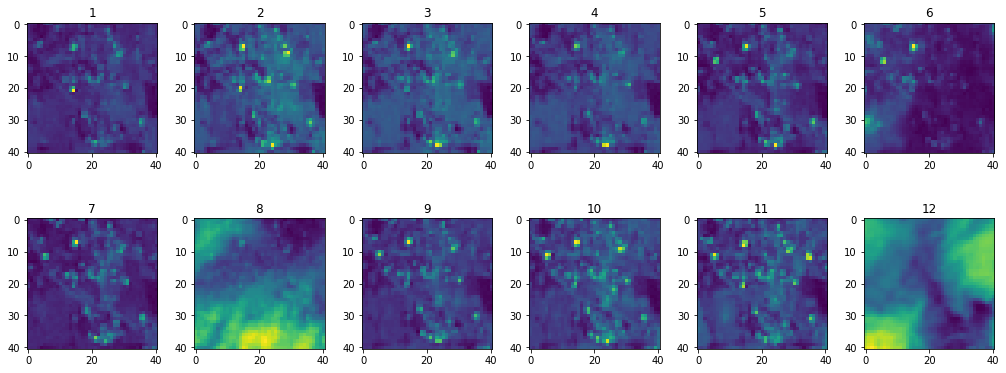

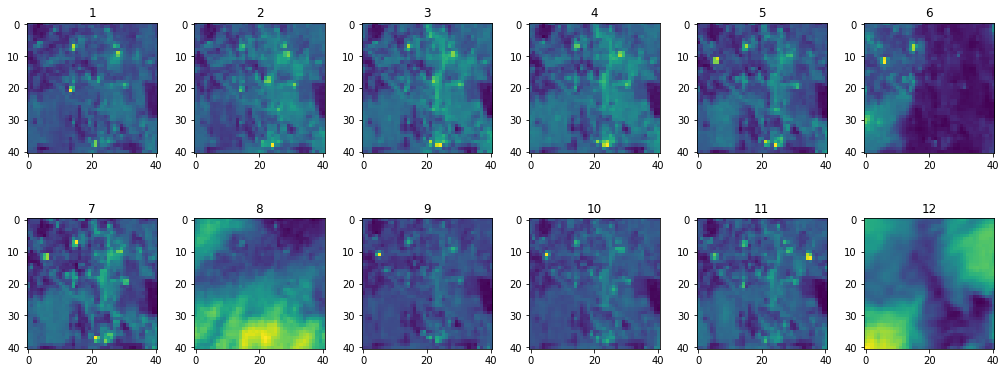

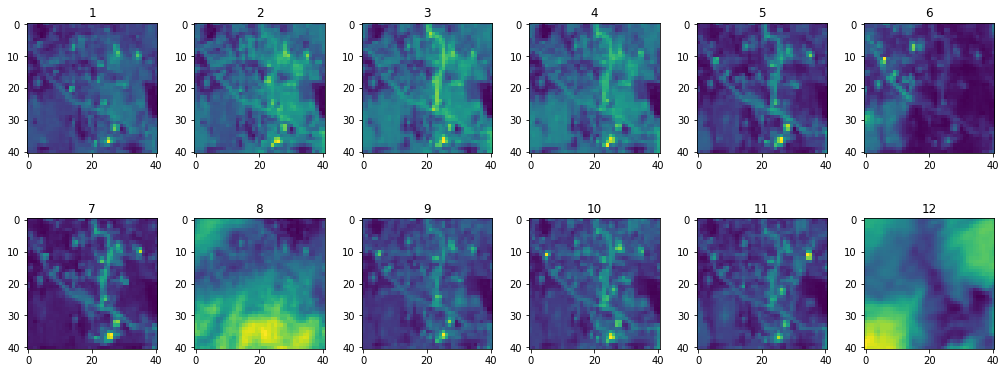

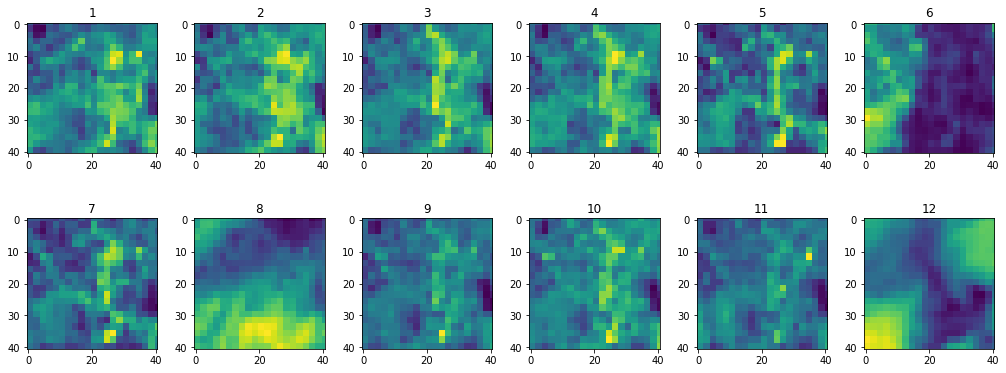

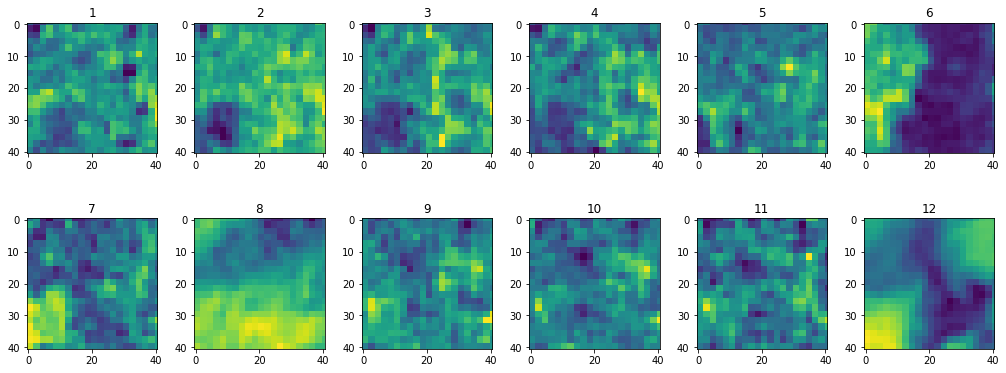

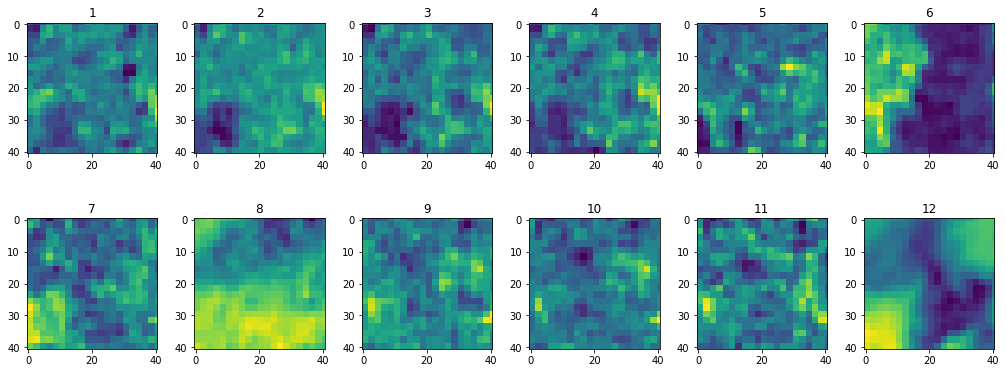

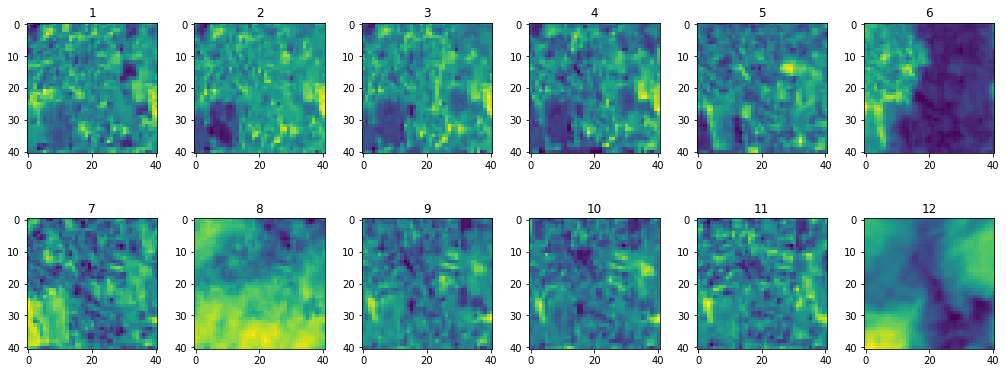

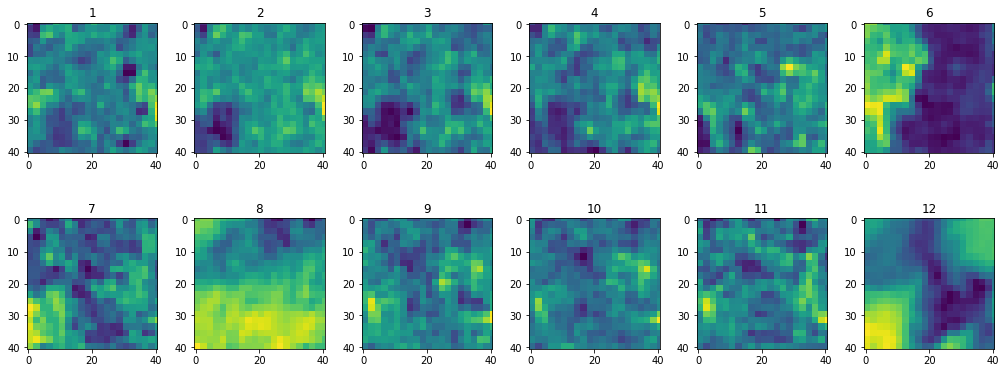

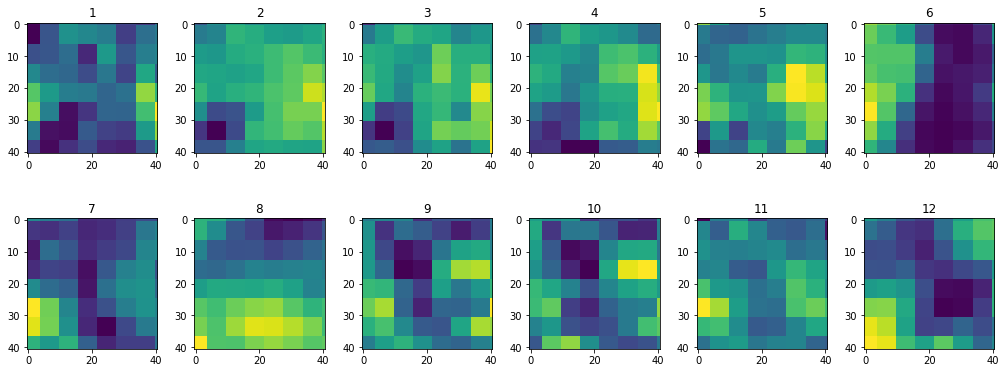

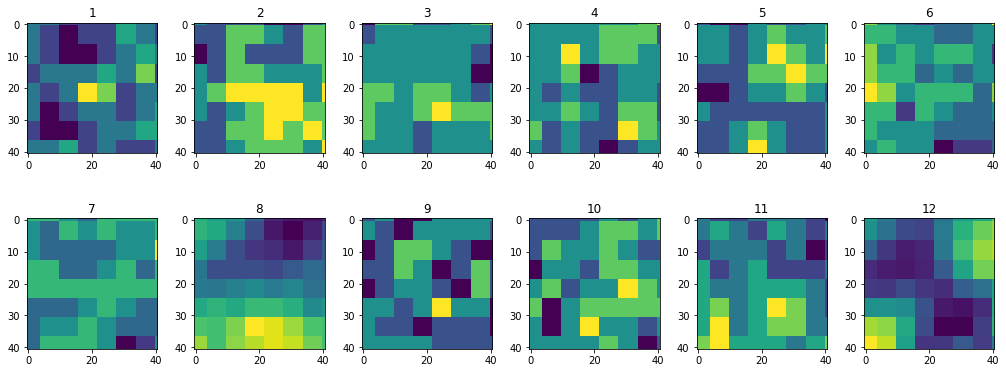

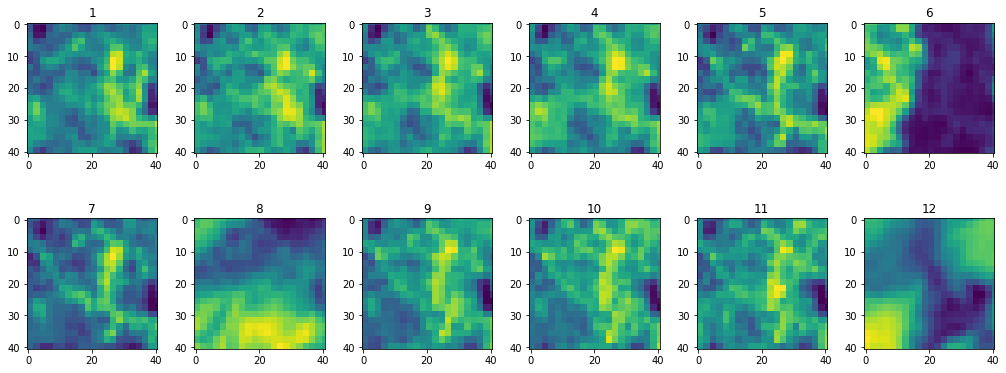

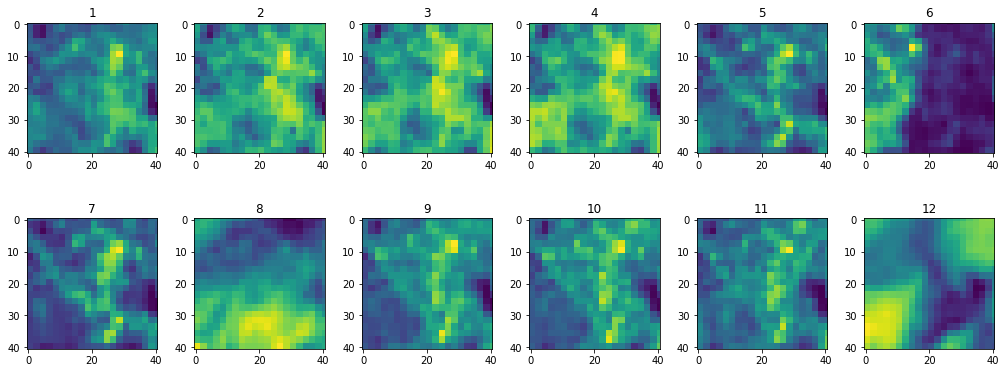

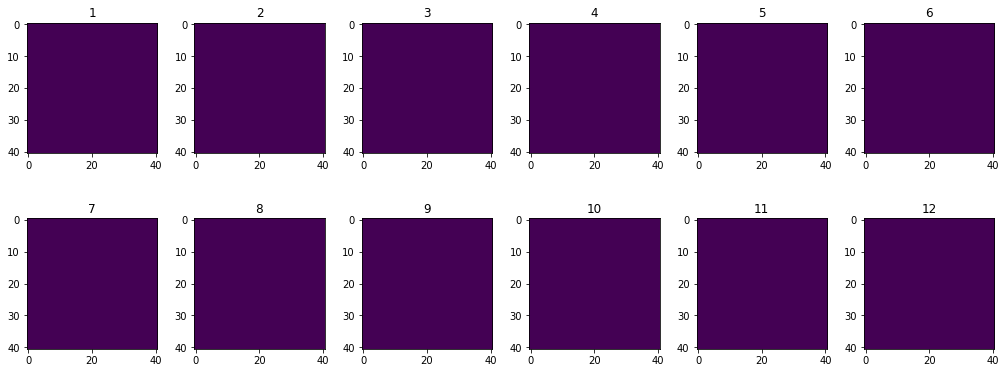

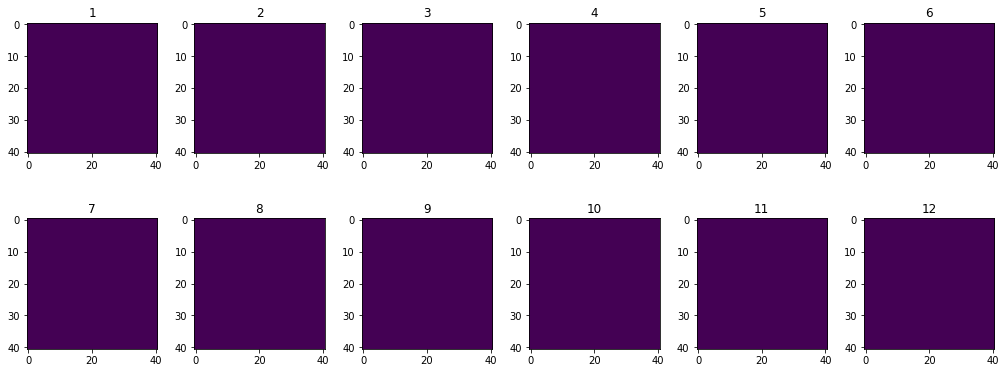

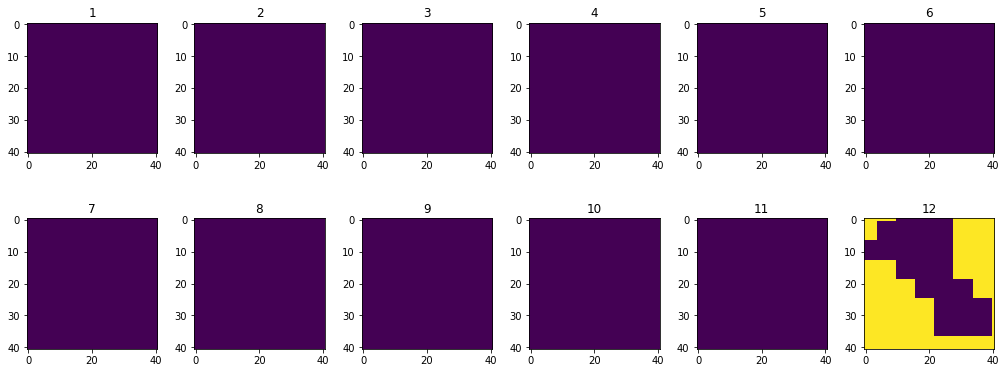

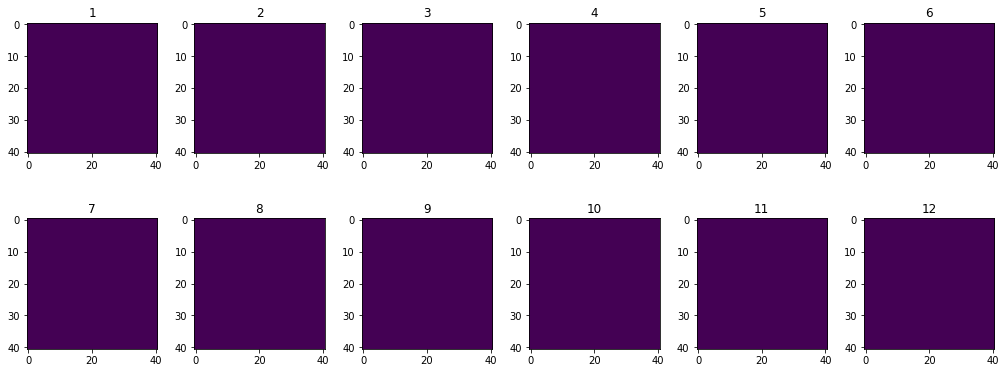

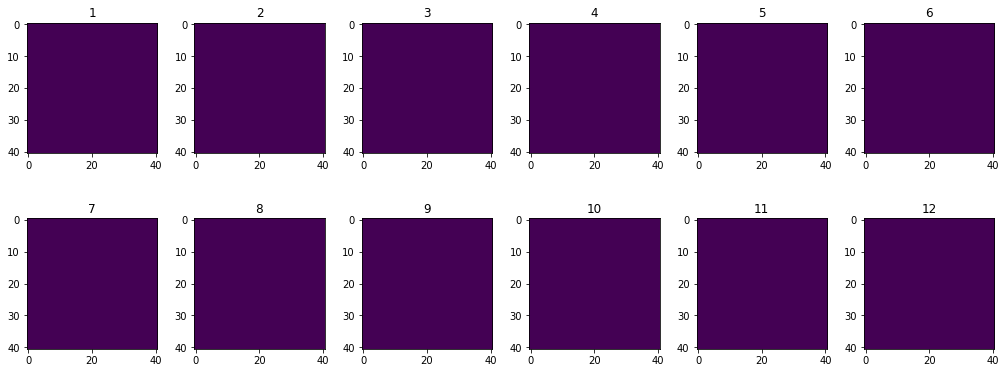

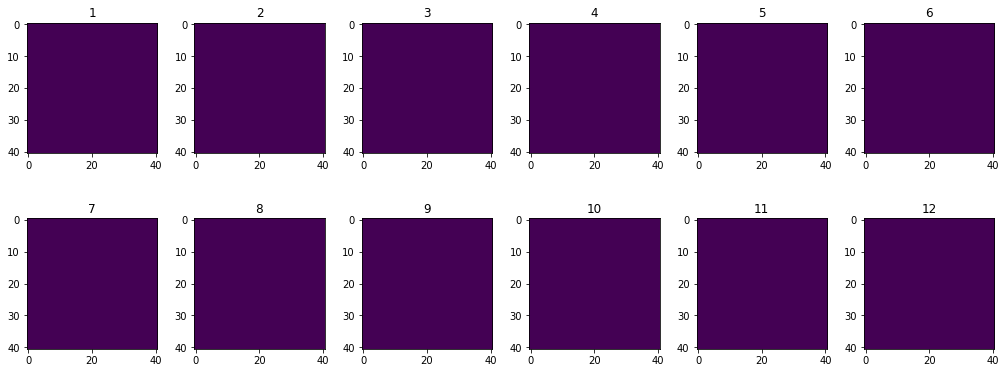

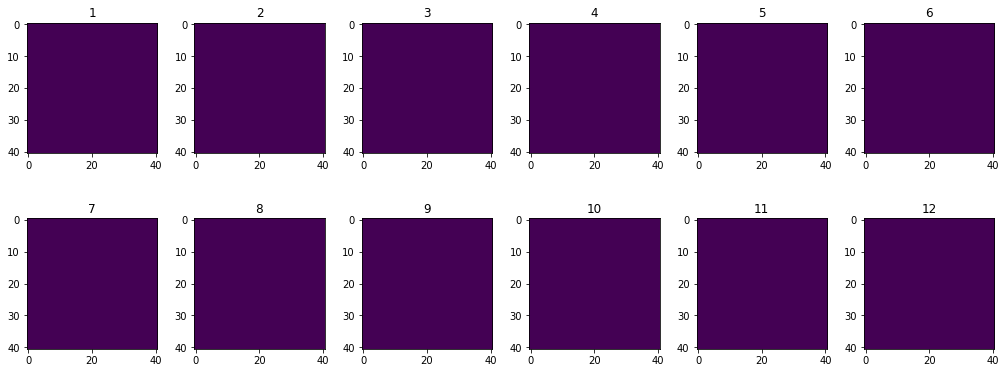

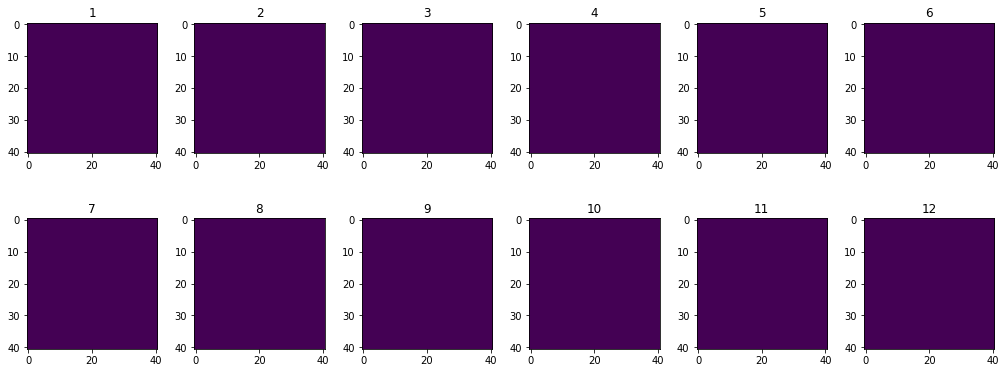

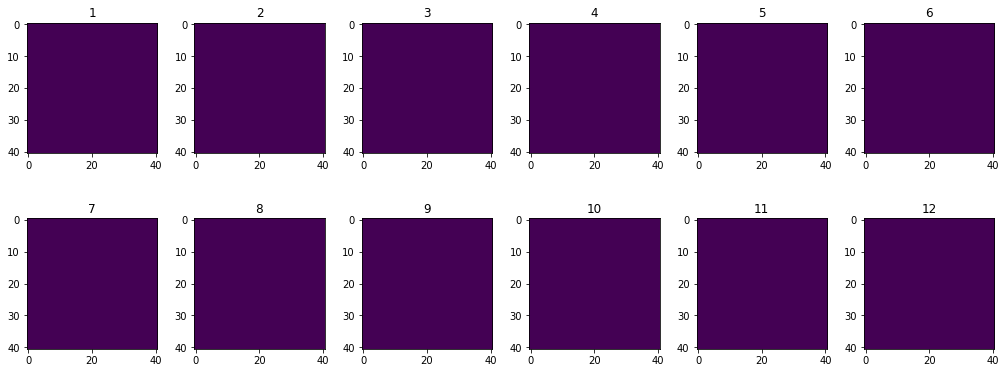

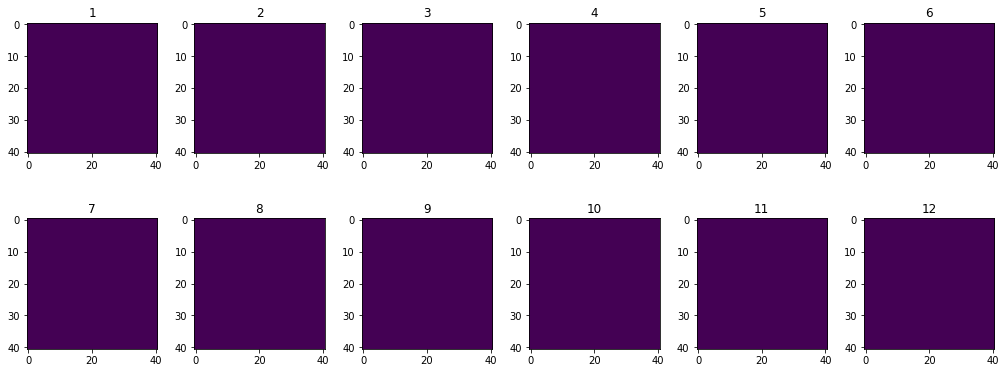

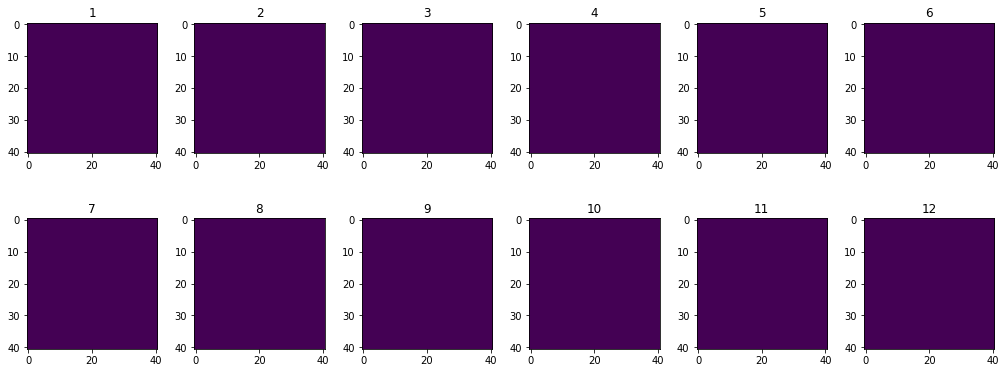

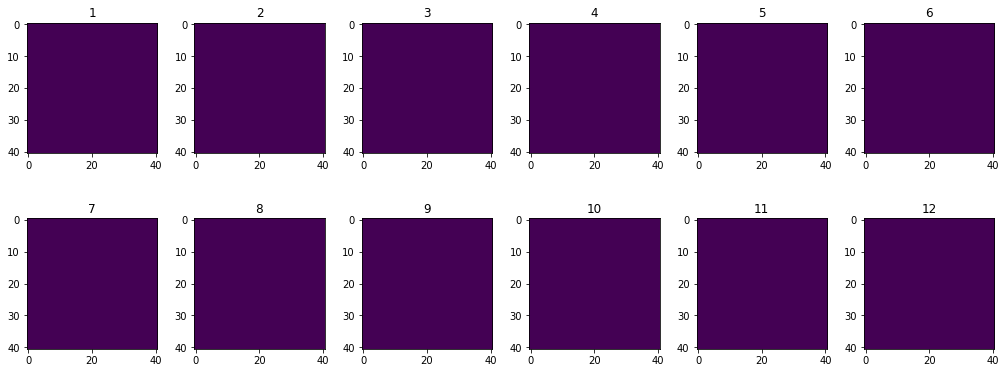

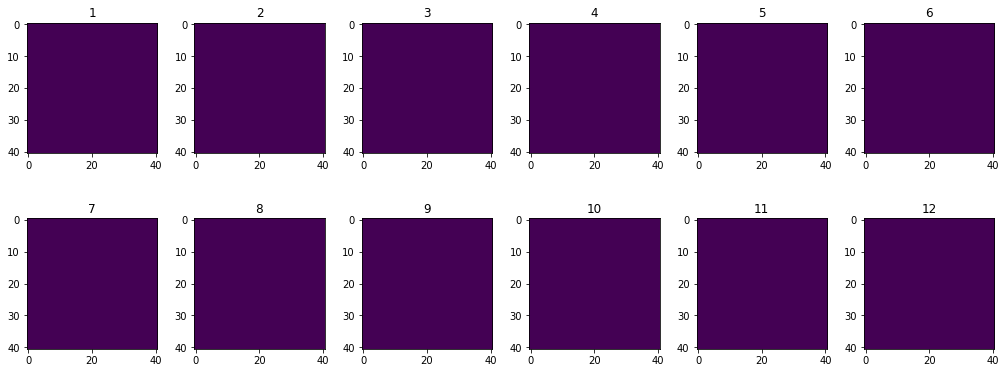

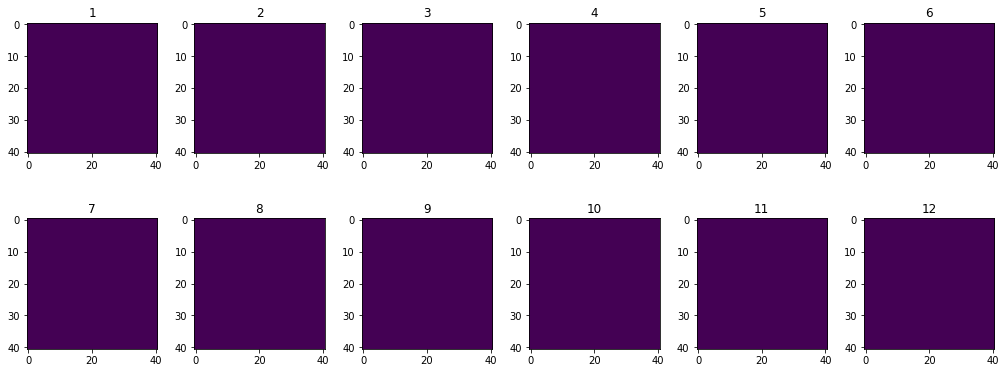

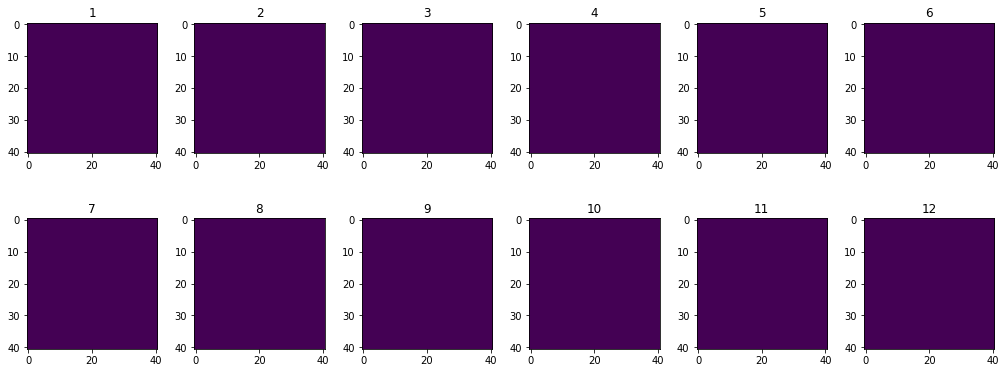

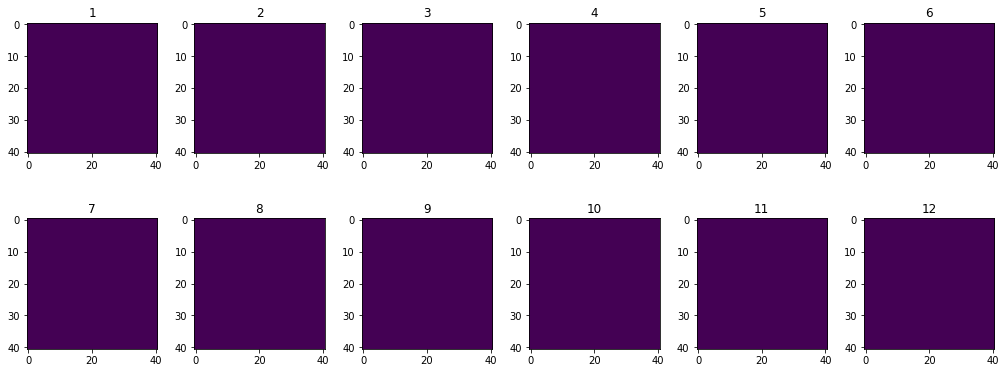

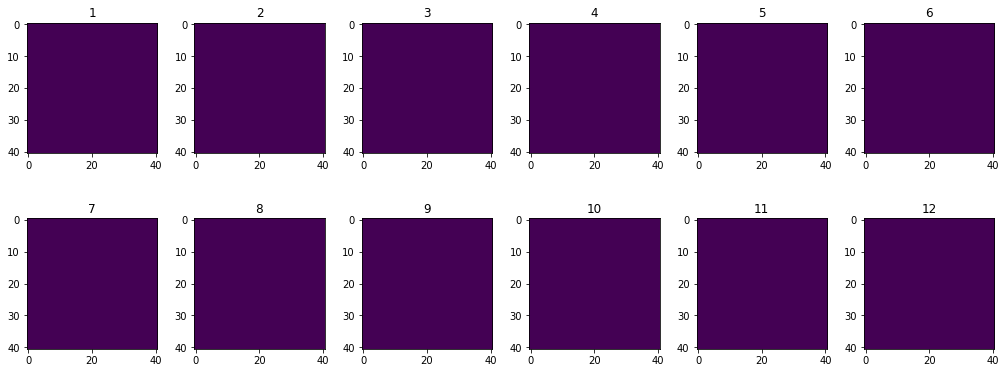

In [50]:
# look at all the images for a single field.

fid = train['Field_ID'].values[300]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')

# load the randomly sampled datapoint image
arr = np.load(fn) # Loading the data with numpy

for j in range(30):
    fig, axs = plt.subplots(2, 6, figsize=(18, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(12):
      image = arr[i*30 + j]
      axs[i].imshow(image)
      axs[i].set_title(str(i+1))

It is immediately evident from viewing the data that bands 14 - 30 do not seem to contain useful data. The data in images from these bands are constant data. We will automate a test to see if this is true. 

In [61]:
good_bands = []
good_images = []
for fid in train['Field_ID'].values:
    fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
    arr = np.load(fn) # Loading the data with numpy
    for j in range(13,30):
        for i in range(12):
            max = np.amax(arr[i*30 + j])
            min = np.min(arr[i*30 + j])
            if min != max:
                if j not in good_bands:
                    good_bands.append(j)
                good_images.append("FID: {}, band: {}, month: {}".format(fid, j, i))
print("Number of good bands in bands 13-30: {}".format(len(good_bands))) 
print("Bands: {}".format(good_bands))

Number of good bands in bands 13-30: 14
Bands: [15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]


It looks as though there are some good images in those bands. The bad bands that offer no data across the entire dataset are bands 13, 14, and 24. These will be excluded from any analysis or feature selection. 

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [7]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

There are a couple ways to train. One way is to consider each image as an example, so that features of the examples are pixels. Each field ID has 360 images: 30 bands, with 12 images per band, corresponding to each month. Reduce features on this training model to find which pixels are most useful. Then once the most useful pixels are determined, change the dataset. Now, examples will be field IDs, where features are different bands in that field ID. The value of each feature will be a pixel value for that band. It is possible to have multiple pixels for a single band, all as different features for that example. 

Here is the training model to determine patch worth. Each example is an patch of pixels within an image, with pixels as features. It is tested with one field ID at a time. The y value for an example image is the yield for the field ID that the image belongs to. This can be a useful tool in finding which patches of the images are good for focusing on.

In [ ]:
def get_image(fid, b, m, w):
    fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
    # load the randomly sampled datapoint image
    arr = np.load(fn) # Loading the data with numpy
    window = []
    for i in w[0]:
        for j in w[1]:
            window.append(arr[m*30 + b][i][j])
    return window


idxs = np.random.choice(range(train.shape[0]), size=200, replace=False)

dfs = []

w = [range(0,10), range(0,10)]

for j in idxs:
    # make a dataframe for the first field id
    df = pd.concat([pd.DataFrame([get_image(train['Field_ID'].values[j], b, m, w)]) 
                    for b in range(30) for m in range(12)], ignore_index=True)
    field_id = []
    yield_vals = []
    months = []
    bands = []
    for i in range(12*30):
        field_id.append(train['Field_ID'].values[j])
        yield_vals.append(train['Yield'].values[j])
    for m in range(12):
        for b in range(30):
            months.append(m)
            bands.append(b)
    df['Month'] = months
    df['Band'] = bands
    df['Field_ID'] = field_id 
    df['Yield'] = yield_vals
    dfs.append(df)

# combine the dataframes in dfs into a single df
df = pd.concat(dfs, ignore_index=True)
# shuffle the rows so that they're randomized
df.sample(frac=1)

The above method proved to be intolerably slow, even for a small sample size of 200 fields (although this is 200 * 360 images, each of which must be reduced to the desired window. This method will not work for patch analysis. Time to think of a new method.

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [334]:
def sample_pixel(fid, pixel_a, pixel_b, month_range, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 
             'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 
             'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 
             'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 
             'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 
             'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
    # exclude bands 13, 14, and 24
    band_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 , 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
    bands_of_interest = [bands[x] for x in band_idxs]
    values = {}
    for month in range(month_range[0], month_range[1]):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        # get the whole image in the form of an array
        vs = np.empty(idxs[0].size)
        i=0
        for idx in idxs[0]:          
            vs[i] = arr[idx, pixel_a, pixel_b]
            i+=1
        #vs = arr[idxs, 20, 20]
        for bn, v in zip(bns, vs):
            values[bn] = v
    return values

# # Example
# process_im('35AFSDD', 20, 20)

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features: Here is an example dataframe with the pixel (20,20). 

In [10]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([sample_pixel(fid, 20, 20) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B1,0_S2_B2,0_S2_B3,0_S2_B4,0_S2_B5,0_S2_B6,0_S2_B7,0_S2_B8,0_S2_B8A,0_S2_B9,...,11_S2_B7,11_S2_B8,11_S2_B8A,11_S2_B9,11_S2_B10,11_S2_B11,11_S2_B12,11_S2_QA10,Field_ID,Yield
0,1024.0,934.0,932.0,1173.0,1392.0,1798.0,2044.0,2038.0,2327.0,1072.0,...,2168.0,1845.0,2307.0,493.0,10.0,985.0,395.0,0.0,MH2O0YH,3.686
1,1023.0,880.0,821.0,924.0,1116.0,1630.0,1870.0,1951.0,2040.0,929.0,...,957.0,891.0,954.0,217.0,10.0,469.0,204.0,0.0,O9TURWL,5.657
2,1095.0,1016.0,1070.0,1357.0,1632.0,1972.0,2256.0,2137.0,2588.0,957.0,...,5461.0,4173.0,5769.0,1723.0,20.0,4898.0,4248.0,0.0,35AFSDD,3.082
3,976.0,777.0,784.0,639.0,1064.0,2014.0,2561.0,2588.0,2921.0,1300.0,...,8976.0,8648.0,9221.0,3587.0,36.0,7406.0,5731.0,0.0,PM05EG9,2.707
4,1300.0,1081.0,1122.0,1162.0,1487.0,2336.0,2698.0,2603.0,2984.0,710.0,...,3421.0,3455.0,3744.0,671.0,11.0,2428.0,1338.0,0.0,V7PZBCG,2.679


We can also try to sample an image, but rather than sampling a single pixel, we can sample a patch by taking the average pixel value over that patch. If we have extra time, we will try this.

In [354]:
def sample_patch(fid, pixel_a, pixel_b, N, month_range, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
  band_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 , 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
  bands_of_interest = [bands[x] for x in band_idxs]
  values = {}
  for month in range(month_range[0], month_range[1]):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    # get the whole image in the form of an array
    vs = np.empty(idxs[0].size)
    i=0
    for idx in idxs[0]:    
        vs[i] = np.mean(arr[idx, pixel_a:pixel_a+N, pixel_b:pixel_b+N])
        i+=1
    for bn, v in zip(bns, vs):
        values[bn] = v
  return values

Now we search for a new model to assess patch value. The following method is slow, but works better than the previous model and seems to give intuitive results. A simple regressor, linear regressor, is trained on each pixel in each patch. Then the whole patch is assessed based on the average error of the regressors for each pixel and the variance of errors is assessed to see if the patch is quite uniform or if it needs to be broken up into smaller patches. This is a good way of eliminating large portions of the image. **If the .csv files for this data exist already, do not run the next cell.**

In [355]:
def make_df(train, pixel_a, pixel_b, idxs, month_range=(0,12)):
    # sample the pixels from train
    train_sampled = pd.DataFrame([sample_pixel(fid, pixel_a, pixel_b, month_range) 
                                  for fid in train['Field_ID'].values[idxs]])
    # Add in the field ID and yield
    train_sampled['Field_ID'] = train['Field_ID'].values[idxs]
    train_sampled['Yield'] = train['Yield'].values[idxs]
    return train_sampled

def make_df_patch(train, pixel_a, pixel_b, size, idxs, month_range=(0,12)):
    # sample the pixels in the patch from train
    train_sampled = pd.DataFrame([sample_patch(fid, pixel_a, pixel_b, size, month_range) 
                                  for fid in train['Field_ID'].values[idxs]])
    # Add in the field ID and yield
    train_sampled['Field_ID'] = train['Field_ID'].values[idxs]
    train_sampled['Yield'] = train['Yield'].values[idxs]
    return train_sampled

def split_train(train):
    # Split the data  
    data_train = train[0:int(np.floor(train.shape[0]*0.7))]
    data_val = train[int(np.floor(train.shape[0]*0.7)):int(np.floor(train.shape[0]*0.9))]
    data_test = train[int(np.floor(train.shape[0]*0.9)):]
    return (data_train, data_val, data_test)

def split_xy(train_sampled):
    # Split the data
    X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']   
    return (X, y)

def split(train_sampled):
    data_train, data_val, data_test = split_train(train_sampled)
    X_train, y_train = split_xy(data_train)
    X_val, y_val = split_xy(data_val)
    X_test, y_test = split_xy(data_test)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [356]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# randpmly sample indices of examples from the training set to train with
#idxs = np.random.choice(range(train.shape[0]), size=train.shape[0], replace=False)
idxs = np.random.choice(range(train.shape[0]), size=train.shape[0], replace=False)

# get a simple model that will provide large variance based on quality of pixel
model = LinearRegression()

# initialize a 2D array to store the score for each pixel (just look at the (40,40) pixels for each image, even
# if the image is 41x41 or 42x42)


# we want to look at pixels rather than patches for now
# pixel_analysis = True
# patch_analysis = False
pixel_analysis = False
patch_analysis = True
if pixel_analysis:
    image_scores = np.zeros((40,40))
    # get the score for each pixel
    for pixel_a in range(0,40):
        for pixel_b in range(0,40):
            # Make a new DF with the sampled values from each field 
            train_sampled = make_df(train, pixel_a, pixel_b, idxs)
            # Split the data
            X_train, y_train, X_val, y_val, _, _  = split(train_sampled)
            # for linear regression, only need to get the score once
            model.fit(X_train, y_train)
            # Score with RMSE
            image_scores[pixel_a, pixel_b] = mean_squared_error(y_val, model.predict(X_val), squared=False)
            print("{}, {}".format(pixel_a, pixel_b))        
    np.savetxt("image_scores_FULL_pixels.csv", image_scores, delimiter=",")
    
elif patch_analysis:
    N = 4
    image_scores = np.zeros((40//N,40//N))
    # get the score for each patch of size N
    for pixel_a in range(0, 40, N):
        for pixel_b in range(0, 40, N):
            # Make a new DF with the sampled values from each field 
            train_sampled = make_df_patch(train, pixel_a, pixel_b, N, idxs)
            # Split the data
            X_train, y_train, X_val, y_val, _, _  = split(train_sampled)
            # for linear regression, only need to get the score once
            model.fit(X_train, y_train)
            # Score with RMSE
            image_scores[pixel_a//N, pixel_b//N] = mean_squared_error(y_val, model.predict(X_val), squared=False)
            print("{}, {}".format(pixel_a, pixel_b))
    np.savetxt("image_scores_FULL_patches.csv", image_scores, delimiter=",")


0, 0
0, 4
0, 8
0, 12
0, 16
0, 20
0, 24
0, 28
0, 32
0, 36
4, 0
4, 4
4, 8
4, 12
4, 16
4, 20
4, 24
4, 28
4, 32
4, 36
8, 0
8, 4
8, 8
8, 12
8, 16
8, 20
8, 24
8, 28
8, 32
8, 36
12, 0
12, 4
12, 8
12, 12
12, 16
12, 20
12, 24
12, 28
12, 32
12, 36
16, 0
16, 4
16, 8
16, 12
16, 16
16, 20
16, 24
16, 28
16, 32
16, 36
20, 0
20, 4
20, 8
20, 12
20, 16
20, 20
20, 24
20, 28
20, 32
20, 36
24, 0
24, 4
24, 8
24, 12
24, 16
24, 20
24, 24
24, 28
24, 32
24, 36
28, 0
28, 4
28, 8
28, 12
28, 16
28, 20
28, 24
28, 28
28, 32
28, 36
32, 0
32, 4
32, 8
32, 12
32, 16
32, 20
32, 24
32, 28
32, 32
32, 36
36, 0
36, 4
36, 8
36, 12
36, 16
36, 20
36, 24
36, 28
36, 32
36, 36


Save the above array of linear regressor values for the pixels to a csv.

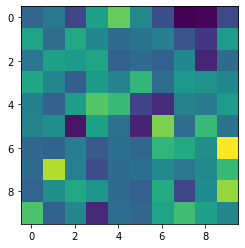

In [357]:
plt.imshow(image_scores)

The above method takes very long to run (between 1-8 hours depending on how much data is included). A faster way to get an approximate representation is through mean pooling of patch segments. Pool together 4x4 squares to obtain the mean pixel value over that 4x4 pixel patch and only train on that mean value. This method is much faster.

Now we can rank the patches in terms of their scores. We are looking for patches that yield the lowest possible average errors. We are also interested in the variance of the patch scores to see if it is a patch that has high topographical variety. We will run more granular patch analysis on the 8x8 patches with high variance.

We now select the best patches as well as the patches with high variance for more granular patch analysis. Now we consider windows with width 5 pixels as opposed to windows with width 8 pixels.

In [358]:
# identify patches of interest in the image

# declare a dictionary that is used to store the mean RMSE of pixels in a patch and the
# variance of the RMSE of the pixels in the patch
patches_data = {}

if pixel_analysis:
    # patch size (e.g., N = 5 will be a 5x5 patch for a total of 25 pixels)
    N = 1
    for i in range(0, 40, N):
        for j in range(0, 40, N):
            pixel_scores = []
            for pixel_a in range(i, i+N):
                for pixel_b in range(j, j+N):
                    pixel_scores.append(image_scores[pixel_a, pixel_b])
            # store data on the patch in a dictionary
            patches_data["({}, {})".format(i, j)] = (np.mean(pixel_scores), np.var(pixel_scores))

elif patch_analysis:
    # patch size (e.g., N = 5 will be a 5x5 patch for a total of 25 pixels)
    N = 4
    for i in range(0, 40//N):
        for j in range(0, 40//N):
            patches_data["({}, {})".format(i*N, j*N)] = image_scores[i,j]

We can take a look at the top patches from this pass as well. 

In [359]:
N  = 10
res = dict(sorted(patches_data.items(), key = itemgetter(1), reverse = False)[:N])
print(res)

{'(0, 28)': 1.642399499545256, '(0, 32)': 1.6442366056694453, '(20, 8)': 1.649258494515802, '(20, 20)': 1.6551607732592655, '(8, 32)': 1.655729501923908, '(36, 12)': 1.6572575510584062, '(16, 24)': 1.6595311294297848, '(4, 32)': 1.6633673813211856, '(16, 20)': 1.6686386770321608, '(0, 8)': 1.6694404682450315}


Now we can select the best patch (or two best patches) and analyze the scores that each pixel yields. In the final model, multiple regressors will be trained on different subsets of the training set, each set focusing on a different pixel in the selected patch. The final model will yield a weighted average of these different regressors, where the weight is inversely proportional to the error of the pixel that the dataset yielded.

Now we can narrow down our search by starting with a wide window and downselecting. Once we have a few small windows, we can look at individual pixel scores within those windows. 

# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

In [331]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

# Model functions
def model_create():
    # Now we must make the models
    models = []
    for i in range(10):
        model = RandomForestRegressor(n_estimators=50, max_depth=6)
        models.append(model)
    return models

def get_weights():
    # Now the model is trained. Now we must populate the weight matrix.
    w = []
    for i in range(5):
        w.append((1/RMSE_pixels[i]) * (1/RMSE_months[0]))
    for i in range(5):
        w.append((1/RMSE_pixels[i]) * (1/RMSE_months[1]))
    return w

def model_train(models, data):
    # Now we must create 10 new datasets for the pixel/harvest month combinations. 
    # add the 5 dataframes for the harvest months
    idxs = [x for x in range(data.shape[0])]
    print(len(idxs))
    df = []
    print("Making dataframes")
    for i in range(5):
        df_temp = make_df(data, pixels_of_interest[i][0], pixels_of_interest[i][1], idxs, month_range=harvest_months)
        df.append(df_temp)
    print("Making the second half of dataframes")
    # add the 5 dataframes for the nonharvest months
    for i in range(5):
        df_temp = make_df(data, pixels_of_interest[i][0], pixels_of_interest[i][1], idxs, month_range=nonharvest_months)
        df.append(df_temp)
    print("Training the models")
    # Now df contains all the 10 dataframes we need for our 10 regressors. Now we can split the dataframes into 
    # training and testing sets and train the model.
    for i in range(10):
        X_train, y_train = split_xy(df[i])
        models[i].fit(X_train, y_train)
    return models

def model_predict(models, w, test):
    df = []
    idxs = [x for x in range(test.shape[0])]
    print("Making the dataframes for prediction")
    for i in range(5):
        df_temp = make_df(test, pixels_of_interest[i][0], pixels_of_interest[i][1], idxs, month_range=harvest_months)
        df.append(df_temp)
    print("Making the second half of dataframes for prediction")
    # add the 5 dataframes for the nonharvest months
    for i in range(5):
        df_temp = make_df(test, pixels_of_interest[i][0], pixels_of_interest[i][1], idxs, month_range=nonharvest_months)
        df.append(df_temp)
    print("Making prediction")
    # now we can make a prediction with the model
    prediction = np.zeros(test.shape[0])
    for i in range(10):
        X_val,_ = split_xy(df[i]) 
        prediction += w[i] * models[i].predict(X_val)
    prediction /= sum(w)
    return prediction

In [333]:
# From a single large dataset, we must split the dataset up based on pixel and harvest month. 
# There are two month categories: harvest months and nonharvest months. They are as follows:
harvest_months = [4,5,6,7,8,9,10]
nonharvest_months = [1,2,3,11,12]
# the errors for these two months
RMSE_months = [1, 1]

# Then we must split the dataset based on the top 5 pixels of interest. They are:
pixel_1 = (18,11)
pixel_2 = (19,25)
pixel_3 = (32,27)
pixel_4 = (35,24)
pixel_5 = (20,20)
pixels_of_interest = [pixel_1, pixel_2, pixel_3, pixel_4, pixel_5]
# the errors for each of these pixels
RMSE_pixels = [1.562893669772938, 1.565668020752039, 1.5662930491128952, 1.5669992616258848, 1.6219651889791495]


# create the model
model = model_create()

# train the model with the training set
data_train, data_val, data_test = split_train(train)
model = model_train(model, data_train)

# now that we have prediction, we can test the accuracy of it by looking at the RMSE.
# get the test set
w = get_weights()
prediction = model_predict(model, w, data_val)

# get the error
_, y_val = split_xy(data_val)
error = mean_squared_error(y_val, prediction, squared=False)
print(error)

1786
Making dataframes
Making the second half of dataframes
Training the models
Making the dataframes for prediction
Making the second half of dataframes for prediction
Making prediction
1.4216915425131602


In [360]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

# Model functions
def model_create():
    # Now we must make the models
    models = []
    for i in range(10):
        model = RandomForestRegressor(n_estimators=50, max_depth=6)
        models.append(model)
    return models

def get_weights_patch():
    # Now the model is trained. Now we must populate the weight matrix.
    w = []
    for i in range(5):
        w.append((1/RMSE_patches[i]) * (1/RMSE_months[0]))
    for i in range(5):
        w.append((1/RMSE_patches[i]) * (1/RMSE_months[1]))
    return w

def model_train_patch(models, data):
    N = 4
    # Now we must create 10 new datasets for the pixel/harvest month combinations. 
    # add the 5 dataframes for the harvest months
    idxs = [x for x in range(data.shape[0])]
    print(len(idxs))
    df = []
    print("Making dataframes")
    for i in range(5):
        df_temp = make_df_patch(data, patches_of_interest[i][0], patches_of_interest[i][1], N, idxs, month_range=harvest_months)
        df.append(df_temp)
    print("Making the second half of dataframes")
    # add the 5 dataframes for the nonharvest months
    for i in range(5):
        df_temp = make_df_patch(data, patches_of_interest[i][0], patches_of_interest[i][1], N, idxs, month_range=nonharvest_months)
        df.append(df_temp)
    print("Training the models")
    # Now df contains all the 10 dataframes we need for our 10 regressors. Now we can split the dataframes into 
    # training and testing sets and train the model.
    for i in range(10):
        X_train, y_train = split_xy(df[i])
        models[i].fit(X_train, y_train)
    return models

def model_predict_patch(models, w, test):
    df = []
    N = 4
    idxs = [x for x in range(test.shape[0])]
    print("Making the dataframes for prediction")
    for i in range(5):
        df_temp = make_df_patch(test, pixels_of_interest[i][0], pixels_of_interest[i][1], N, idxs, month_range=harvest_months)
        df.append(df_temp)
    print("Making the second half of dataframes for prediction")
    # add the 5 dataframes for the nonharvest months
    for i in range(5):
        df_temp = make_df_patch(test, pixels_of_interest[i][0], pixels_of_interest[i][1], N, idxs, month_range=nonharvest_months)
        df.append(df_temp)
    print("Making prediction")
    # now we can make a prediction with the model
    prediction = np.zeros(test.shape[0])
    for i in range(10):
        X_val,_ = split_xy(df[i]) 
        prediction += w[i] * models[i].predict(X_val)
    prediction /= sum(w)
    return prediction

In [361]:
# From a single large dataset, we must split the dataset up based on pixel and harvest month. 
# There are two month categories: harvest months and nonharvest months. They are as follows:
harvest_months = [4,5,6,7,8,9,10]
nonharvest_months = [1,2,3,11,12]
# the errors for these two months
RMSE_months = [1, 1]

# Then we must split the dataset based on the top 5 pixels of interest. They are:
patch_1 = (0,28)
patch_2 = (0,32)
patch_3 = (20,8)
patch_4 = (20,20)
patch_5 = (8,32)
patches_of_interest = [patch_1, patch_2, patch_3, patch_4, patch_5]
# the errors for each of these pixels
RMSE_patches = [1.642399499545256, 1.6442366056694453, 1.649258494515802, 1.6551607732592655, 1.655729501923908]

# create the model
model = model_create()

# train the model with the training set
data_train, data_val, data_test = split_train(train)
model = model_train_patch(model, data_train)

# now that we have prediction, we can test the accuracy of it by looking at the RMSE.
# get the test set
w = get_weights_patch()
prediction = model_predict_patch(model, w, data_val)

# get the error
_, y_val = split_xy(data_val)
error = mean_squared_error(y_val, prediction, squared=False)
print(error)

1786
Making dataframes
Making the second half of dataframes
Training the models
Making the dataframes for prediction
Making the second half of dataframes for prediction
Making prediction
1.4190318831567974


# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [62]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(test_sampled)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.375058
1,1WGGS1Q,3.304667
2,EG2KXE2,3.472369
3,HC3GQXF,3.573870
4,7AK6GFK,3.276695
